# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, GlobalMaxPooling1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization,Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import datasets as ds
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# read data

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
# display(df.head(5))
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ['labels','text']
display(df.head(5))

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# prepare and split

In [4]:
# convert labels to binary
CLASSES = {'ham': 0,'spam': 1}
df['labels'] = df['labels'].map(CLASSES)
# df['labels'] = [0 if x=='ham' else 1 for x in df['labels']]

In [5]:
# split train/test
x_train, x_test, y_train, y_test = train_test_split(df['text'].values, df['labels'].values, test_size=0.33)

In [6]:
# machine learning cant train on string so we need to convert worsd into numerical values -- embeddings like fastext or word2vec can be used
# here we will map words into a integer values in a dictionary and learn word embedding instead
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
# dictionary built
word2idx = tokenizer.word_index
VOCAB_LENGTH = len(word2idx)
print(f'maped {VOCAB_LENGTH} unique tokens.')
print(word2idx)



maped 7137 unique tokens.
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'your': 12, 'of': 13, 'for': 14, 'it': 15, 'call': 16, 'have': 17, 'on': 18, '2': 19, 'are': 20, 'that': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'do': 26, 'or': 27, "i'm": 28, 'at': 29, 'can': 30, 'no': 31, 'get': 32, 'ur': 33, 'if': 34, 'be': 35, 'will': 36, 'just': 37, 'with': 38, 'this': 39, 'we': 40, 'up': 41, '4': 42, 'gt': 43, 'ok': 44, 'lt': 45, 'from': 46, 'out': 47, 'go': 48, 'know': 49, 'free': 50, 'when': 51, 'how': 52, 'good': 53, 'what': 54, 'all': 55, 'like': 56, 'got': 57, 'was': 58, 'its': 59, 'come': 60, 'only': 61, 'then': 62, 'day': 63, 'am': 64, 'time': 65, 'send': 66, 'he': 67, 'there': 68, 'home': 69, 'as': 70, 'love': 71, 'text': 72, 'by': 73, 'txt': 74, 'want': 75, 'one': 76, 'about': 77, 'going': 78, 'da': 79, 'r': 80, 'n': 81, 'still': 82, 'stop': 83, 'she': 84, "i'll": 85, 'need': 86, 'sorry': 87, 'reply': 88, 'back': 89, 'our

In [7]:
# map sentences into list of integers
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
print(f'words before tokenizing ==> {x_train[0]}\nwords after tokenizing ==> {sequences_train[0]}')

words before tokenizing ==> So your telling me I coulda been your real Valentine and I wasn't? U never pick me for NOTHING!!
words after tokenizing ==> [23, 12, 885, 10, 1, 3387, 118, 12, 324, 886, 7, 1, 887, 6, 285, 175, 10, 14, 294]


In [8]:
# pad all sentences to same lenght
# used default pre padding since RNN will forgot what is learned at the beggining if we add the padding at the end


padded_train = pad_sequences(sequences_train) # instaed of looping to get longhest sentence to pad to we can just pass the list to pad and will automatically do that
print('Max sentence lenght in train:', padded_train.shape[1])

# Max_SENTENCE = TIME STEPS
TIMESTEPS = padded_train.shape[1]

padded_test = pad_sequences(sequences_test, maxlen=TIMESTEPS)

Max sentence lenght in train: 121


# Train the LSTM/RNN

In [9]:
TIMESTEPS# Create the model
tf.keras.backend.clear_session()
# We get to choose embedding dimensionality
EMB_DIM = 30 

# embedding is of shape VOCAB_LENGTH+1 x EMB_DIM
# (VOCAB_LENGTH+1) because we also have the padding that doesnt exist in dictionary wich is 0 here

i = Input(shape=(TIMESTEPS,))
x = Embedding(VOCAB_LENGTH + 1, EMB_DIM)(i)


# ==== LSMT PORTION
# x = LSTM(5, return_sequences=True)(x)
# x = GlobalMaxPooling1D()(x)
# ====

# ==== CNN PORTION
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(32, 3, strides=2, activation='relu')(x)
# ====





x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x) # sigmoid since its binary clasification


model = Model(i, x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 121, 30)           214140    
_________________________________________________________________
conv1d (Conv1D)              (None, 121, 32)           2912      
_________________________________________________________________
batch_normalization (BatchNo (None, 121, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 32)            3104      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

In [10]:
r = model.fit(padded_train, y_train,epochs=10, validation_data=(padded_test, y_test))

Epoch 1/10
117/117 [==============================] - 3s 19ms/step - loss: 0.3790 - accuracy: 0.8389 - val_loss: 0.4789 - val_accuracy: 0.8575
Epoch 2/10
117/117 [==============================] - 2s 15ms/step - loss: 0.0279 - accuracy: 0.9956 - val_loss: 0.3526 - val_accuracy: 0.8760
Epoch 3/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.9418
Epoch 4/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1143 - val_accuracy: 0.9695
Epoch 5/10
117/117 [==============================] - 2s 16ms/step - loss: 8.1892e-04 - accuracy: 1.0000 - val_loss: 0.0733 - val_accuracy: 0.9793
Epoch 6/10
117/117 [==============================] - 2s 17ms/step - loss: 6.2259e-04 - accuracy: 1.0000 - val_loss: 0.0673 - val_accuracy: 0.9831
Epoch 7/10
117/117 [==============================] - 2s 16ms/step - loss: 3.9739e-04 - accuracy: 1.0000 - val_loss: 0.0686 - val_accu

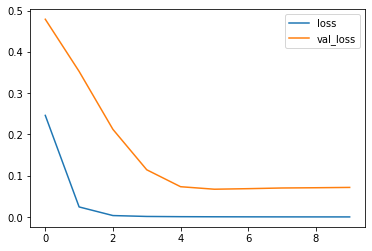

In [11]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

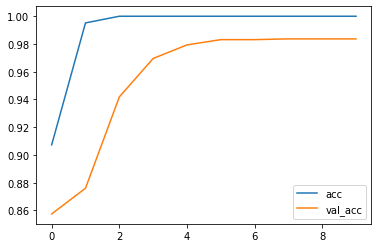

In [12]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [13]:
# Evaluate the model
print(model.evaluate(padded_test, y_test))

58/58 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9837
[0.07162448763847351, 0.9836868047714233]


Confusion matrix, without normalization
[[1577    0]
 [ 262    0]]


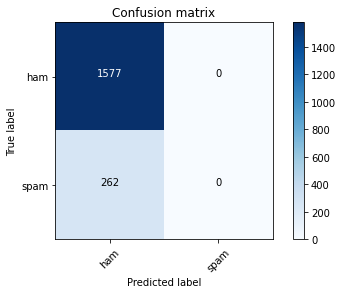

In [14]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(padded_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, CLASSES)



In [15]:
# Show some misclassified examples
INV_CLASSES = {v: k for k, v in CLASSES.items()}
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
print(f"True label: {INV_CLASSES[y_test[i]]} Predicted: {INV_CLASSES[y_test[i]]}")
print('--------')
print(x_test[i])

True label: spam Predicted: spam
--------
I don't know u and u don't know me. Send CHAT to 86688 now and let's find each other! Only 150p/Msg rcvd. HG/Suite342/2Lands/Row/W1J6HL LDN. 18 years or over.
